## DSE 220 - Homework 4: Cluster IRI data

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans, AgglomerativeClustering
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df_demo = pd.read_hdf('yogurt.h5', 'demos')
df_demo.keys()

Index([u'ALL_TVS', u'Age Group Applied to Female HH',
       u'Age Group Applied to Male HH', u'CABL_TVS', u'COUNTY',
       u'Children Group Code', u'Combined Pre-Tax Income of HH', u'EXT_FACT',
       u'Education Level Reached by Female HH',
       u'Education Level Reached by Male HH', u'FIPSCODE', u'Family Size',
       u'Female Working Hour Code', u'HH_AGE', u'HH_EDU', u'HH_OCC',
       u'HH_RACE', u'IRI Geography Number', u'Language',
       u'Male Working Hour Code', u'Marital Status', u'Number of Cats',
       u'Number of Dogs', u'Occupation Code of Female HH',
       u'Occupation Code of Male HH', u'Panelist ID', u'RACE3',
       u'Type of Residential Possession', u'Year', u'ZIPCODE', u'filename',
       u'yearID'],
      dtype='object')

In [44]:
df_panel=pd.read_hdf('yogurt.h5','panel')
df_panel.keys()
df_panel.head()

,COLUPC,DOLLARS,IRI_KEY,MINUTE,OUTLET,PANID,UNITS,WEEK,file
0,17047000300,0.99,1097117,5068,DK,3138826,1,1514,yogurt_PANEL_DK_1479_1530.DAT
1,17047000302,0.89,1097117,2224,DK,3138826,1,1489,yogurt_PANEL_DK_1479_1530.DAT
2,17047000650,0.89,1097117,6551,DK,3138826,1,1488,yogurt_PANEL_DK_1479_1530.DAT
3,17047000650,2.97,1097117,6177,DK,3182048,3,1526,yogurt_PANEL_DK_1479_1530.DAT
4,17047001372,1.49,1097117,973,DK,3184911,1,1495,yogurt_PANEL_DK_1479_1530.DAT


### Selecting Clustering Attributes

My plan is to cluster the panelist purchase data and then use the demographic data help me interpret the resulting clusters.  To give a more meaningful clustering, I'm going to only look at data from one month (4 consecutive weeks) instead of over multiple years.

Not all of the attributes of the panelist purchase data is useful for clustering.  For example the Week will only hurt the clustering as two purchases could be very similar but occur a different parts of the year.  Also COLUPC is just a product ID and not very helpful.  I will be using DOLLARS, MINUTE,OUTLET and UNITS to cluster.  Clustering with these will hopefully give insights into purchasing patterns

In [45]:
#Convert categorical attribute to seperate binary attributes:
Outlet=pd.get_dummies(df_panel["OUTLET"])
df_panel['Drug']=Outlet.ix[:,0]+Outlet.ix[:,1]
df_panel['Groc']=Outlet.ix[:,2]+Outlet.ix[:,3]
df_panel['Mass']=Outlet.ix[:,5]+Outlet.ix[:,6]

#Subset data -- One month of data
OneMonth=df_panel[(df_panel['WEEK']>=1670) & (df_panel['WEEK']<=1673)].dropna()
OneMonth.head()

,COLUPC,DOLLARS,IRI_KEY,MINUTE,OUTLET,PANID,UNITS,WEEK,file,Drug,Groc,Mass
0,15215904001,0.99,650679,5302,DK,1153163,1,1672,yogurt_PANEL_DK_1635_1686.DAT,1,0,0
56,13450063529,1.18,257871,9485,GK,3801233,2,1673,yogurt_PANEL_GK_1635_1686.DAT,0,1,0
132,13450063530,1.18,257871,9485,GK,3801233,2,1673,yogurt_PANEL_GK_1635_1686.DAT,0,1,0
279,13450063533,1.18,257871,9485,GK,3801233,2,1673,yogurt_PANEL_GK_1635_1686.DAT,0,1,0
466,13450063549,0.59,257871,6906,GK,3822619,1,1673,yogurt_PANEL_GK_1635_1686.DAT,0,1,0


In [50]:
#Normalize the data:
normalized = normalize(OneMonth[['DOLLARS','MINUTE','UNITS','Drug','Groc','Mass']])

### KMeans Clustering

Since I only have 4 attributes to use in my cluster, the relatively simple KMeans is a good place to start.  First is to choose a k:

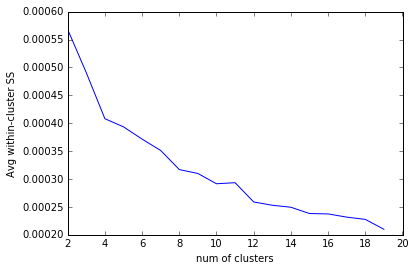

In [59]:
K = range(2,20)
KM = [KMeans(n_clusters=k,init='k-means++').fit(normalized) for k in K]
centroids = [k.cluster_centers_ for k in KM]
D_k = [cdist(normalized, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/normalized.shape[0] for d in dist]
plt.plot(K, avgWithinSS)
plt.xlabel('num of clusters')
plt.ylabel('Avg within-cluster SS')

Looking at the above graph, k=4 clusters looks reasonable.  Initially, looking at the graph, I was thinking k=8 since things tend to level after that point.  But the difference between k=4 and k=8 is not large enough in my opinion to warrent the extra complexity.  So, to start I will use k=4. 

In [60]:
KM=KMeans(n_clusters=4, init='k-means++')
KM.fit(normalized)
OneMonth['Cluster']=KM.labels_

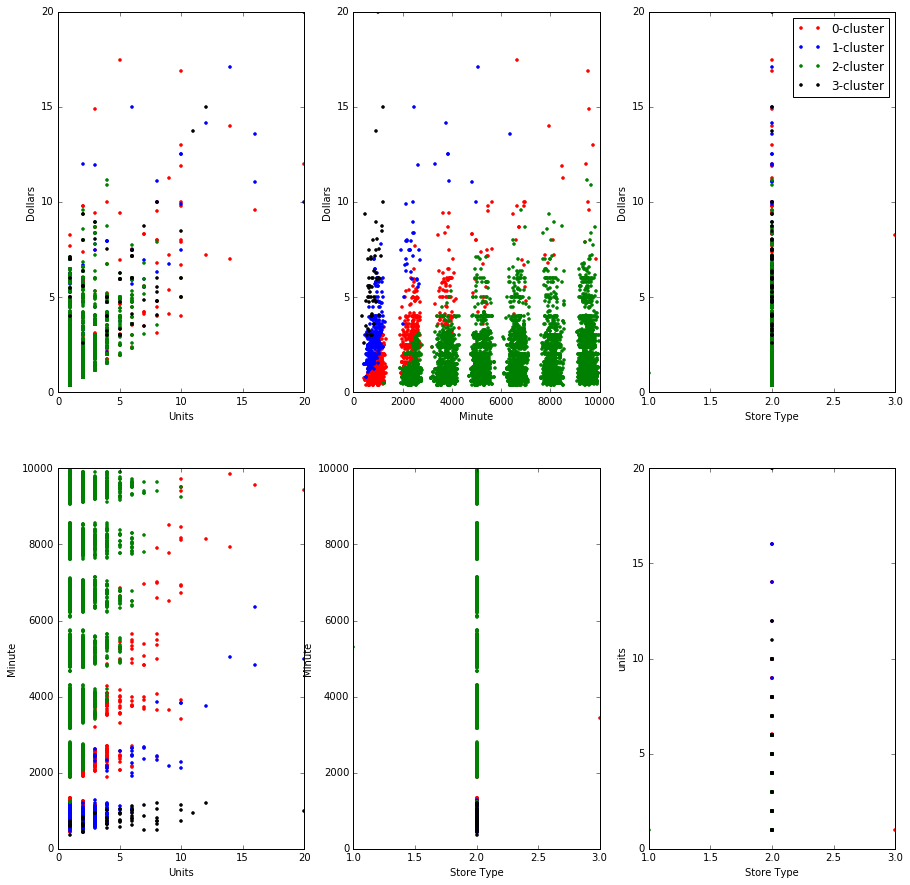

In [92]:
OneMonth['plotStore']=OneMonth['Drug']+2*OneMonth['Groc']+3*OneMonth['Mass']
Cluster0=OneMonth[OneMonth['Cluster']==0]
Cluster1=OneMonth[OneMonth['Cluster']==1]
Cluster2=OneMonth[OneMonth['Cluster']==2]
Cluster3=OneMonth[OneMonth['Cluster']==3]

f, axarr = plt.subplots(2,3,figsize=(15,15))
axarr[0,0].plot(Cluster0['UNITS'],Cluster0['DOLLARS'],'r.',label='0-cluster')
axarr[0,0].plot(Cluster1['UNITS'],Cluster1['DOLLARS'],'b.',label='1-cluster')
axarr[0,0].plot(Cluster2['UNITS'],Cluster2['DOLLARS'],'g.',label='2-cluster')
axarr[0,0].plot(Cluster3['UNITS'],Cluster3['DOLLARS'],'k.',label='3-cluster')
axarr[0,0].set_xlabel('Units')
axarr[0,0].set_ylabel('Dollars')

axarr[0,1].plot(Cluster0['MINUTE'],Cluster0['DOLLARS'],'r.',label='0-cluster')
axarr[0,1].plot(Cluster1['MINUTE'],Cluster1['DOLLARS'],'b.',label='1-cluster')
axarr[0,1].plot(Cluster2['MINUTE'],Cluster2['DOLLARS'],'g.',label='2-cluster')
axarr[0,1].plot(Cluster3['MINUTE'],Cluster3['DOLLARS'],'k.',label='3-cluster')
axarr[0,1].set_xlabel('Minute')
axarr[0,1].set_ylabel('Dollars')

axarr[0,2].plot(Cluster0['plotStore'],Cluster0['DOLLARS'],'r.',label='0-cluster')
axarr[0,2].plot(Cluster1['plotStore'],Cluster1['DOLLARS'],'b.',label='1-cluster')
axarr[0,2].plot(Cluster2['plotStore'],Cluster2['DOLLARS'],'g.',label='2-cluster')
axarr[0,2].plot(Cluster3['plotStore'],Cluster3['DOLLARS'],'k.',label='3-cluster')
axarr[0,2].legend(['0-cluster','1-cluster','2-cluster','3-cluster'])
axarr[0,2].set_xlabel('Store Type')
axarr[0,2].set_ylabel('Dollars')

axarr[1,0].plot(Cluster0['UNITS'],Cluster0['MINUTE'],'r.',label='0-cluster')
axarr[1,0].plot(Cluster1['UNITS'],Cluster1['MINUTE'],'b.',label='1-cluster')
axarr[1,0].plot(Cluster2['UNITS'],Cluster2['MINUTE'],'g.',label='2-cluster')
axarr[1,0].plot(Cluster3['UNITS'],Cluster3['MINUTE'],'k.',label='3-cluster')
axarr[1,0].set_xlabel('Units')
axarr[1,0].set_ylabel('Minute')

axarr[1,1].plot(Cluster0['plotStore'],Cluster0['MINUTE'],'r.',label='0-cluster')
axarr[1,1].plot(Cluster1['plotStore'],Cluster1['MINUTE'],'b.',label='1-cluster')
axarr[1,1].plot(Cluster2['plotStore'],Cluster2['MINUTE'],'g.',label='2-cluster')
axarr[1,1].plot(Cluster3['plotStore'],Cluster3['MINUTE'],'k.',label='3-cluster')
axarr[1,1].set_xlabel('Store Type')
axarr[1,1].set_ylabel('Minute')

axarr[1,2].plot(Cluster0['plotStore'],Cluster0['UNITS'],'r.',label='0-cluster')
axarr[1,2].plot(Cluster1['plotStore'],Cluster1['UNITS'],'b.',label='1-cluster')
axarr[1,2].plot(Cluster2['plotStore'],Cluster2['UNITS'],'g.',label='2-cluster')
axarr[1,2].plot(Cluster3['plotStore'],Cluster3['UNITS'],'k.',label='3-cluster')
axarr[1,2].set_xlabel('Store Type')
axarr[1,2].set_ylabel('units')


In [94]:
Cluster0[['DOLLARS','UNITS','MINUTE','plotStore']].describe()

,DOLLARS,UNITS,MINUTE,plotStore
count,1324.000000,1324.000000,1324.000000,1324.000000
mean,2.038918,1.926760,1749.768127,2.000755
std,1.945476,1.769853,1410.879806,0.027482
min,0.390000,1.000000,446.000000,2.000000
25%,0.807500,1.000000,885.000000,2.000000
50%,1.250000,1.000000,1095.000000,2.000000
75%,2.500000,2.000000,2311.500000,2.000000
max,17.450000,20.000000,9847.000000,3.000000


In [95]:
Cluster1[['DOLLARS','UNITS','MINUTE','plotStore']].describe()

,DOLLARS,UNITS,MINUTE,plotStore
count,476.000000,476.000000,476.000000,476
mean,3.183235,2.319328,974.640756,2
std,2.153019,2.056805,641.745478,0
min,0.800000,1.000000,446.000000,2
25%,2.000000,1.000000,687.000000,2
50%,2.500000,2.000000,823.000000,2
75%,3.297500,3.000000,982.000000,2
max,17.080000,20.000000,6362.000000,2


In [96]:
Cluster2[['DOLLARS','UNITS','MINUTE','plotStore']].describe()

,DOLLARS,UNITS,MINUTE,plotStore
count,7073.000000,7073.000000,7073.000000,7073.000000
mean,1.648302,1.498515,6423.367595,1.999859
std,1.233164,0.888927,2374.783581,0.011890
min,0.390000,1.000000,1233.000000,1.000000
25%,0.790000,1.000000,4282.000000,2.000000
50%,1.200000,1.000000,6620.000000,2.000000
75%,2.290000,2.000000,8280.000000,2.000000
max,11.160000,10.000000,9960.000000,2.000000


In [97]:
Cluster3[['DOLLARS','UNITS','MINUTE','plotStore']].describe()

,DOLLARS,UNITS,MINUTE,plotStore
count,58.000000,58.000000,58.000000,58
mean,6.209310,5.327586,794.310345,2
std,2.998491,3.389291,202.526429,0
min,2.580000,1.000000,351.000000,2
25%,4.752500,3.000000,644.250000,2
50%,5.765000,5.000000,752.000000,2
75%,7.127500,7.000000,941.750000,2
max,20.000000,20.000000,1208.000000,2


Looking at the above graphs and statistics on the different clusters, I have a few observations:
* Cluster 3 appears to contains sales with higher priced items and higher quantity sales
* Cluster 2 appears to contain sales later in the day, lower priced items and lower quantity
* Cluster 1 appears to contain sales earlier in the day
* Cluster 1 and 0 appear to have similar priced and quanity sales

### Hierarchical Clustering

Now, lets try a little more complicated clustering. Again, lets start with 4 clusters 

In [100]:
n_clusters = 4  # number of regions
ward = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
ward.fit(normalized)
OneMonth['Hcluster']=ward.labels_

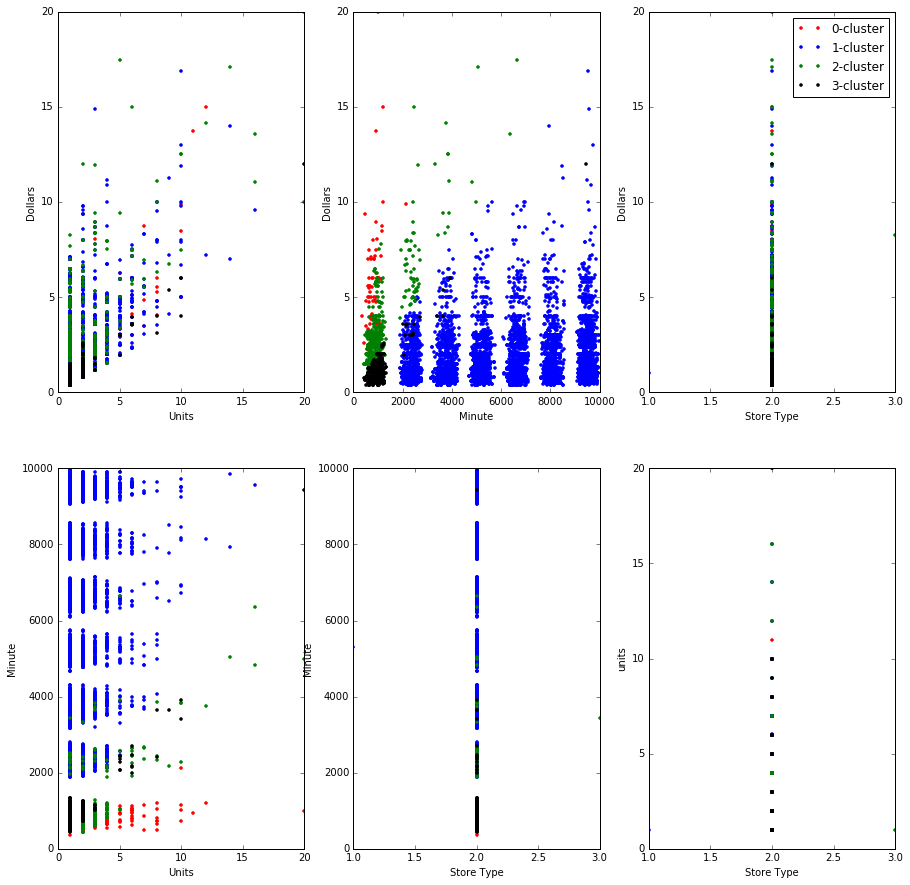

In [102]:
Cluster0=OneMonth[OneMonth['Hcluster']==0]
Cluster1=OneMonth[OneMonth['Hcluster']==1]
Cluster2=OneMonth[OneMonth['Hcluster']==2]
Cluster3=OneMonth[OneMonth['Hcluster']==3]

f, axarr = plt.subplots(2,3,figsize=(15,15))
axarr[0,0].plot(Cluster0['UNITS'],Cluster0['DOLLARS'],'r.',label='0-cluster')
axarr[0,0].plot(Cluster1['UNITS'],Cluster1['DOLLARS'],'b.',label='1-cluster')
axarr[0,0].plot(Cluster2['UNITS'],Cluster2['DOLLARS'],'g.',label='2-cluster')
axarr[0,0].plot(Cluster3['UNITS'],Cluster3['DOLLARS'],'k.',label='3-cluster')
axarr[0,0].set_xlabel('Units')
axarr[0,0].set_ylabel('Dollars')

axarr[0,1].plot(Cluster0['MINUTE'],Cluster0['DOLLARS'],'r.',label='0-cluster')
axarr[0,1].plot(Cluster1['MINUTE'],Cluster1['DOLLARS'],'b.',label='1-cluster')
axarr[0,1].plot(Cluster2['MINUTE'],Cluster2['DOLLARS'],'g.',label='2-cluster')
axarr[0,1].plot(Cluster3['MINUTE'],Cluster3['DOLLARS'],'k.',label='3-cluster')
axarr[0,1].set_xlabel('Minute')
axarr[0,1].set_ylabel('Dollars')

axarr[0,2].plot(Cluster0['plotStore'],Cluster0['DOLLARS'],'r.',label='0-cluster')
axarr[0,2].plot(Cluster1['plotStore'],Cluster1['DOLLARS'],'b.',label='1-cluster')
axarr[0,2].plot(Cluster2['plotStore'],Cluster2['DOLLARS'],'g.',label='2-cluster')
axarr[0,2].plot(Cluster3['plotStore'],Cluster3['DOLLARS'],'k.',label='3-cluster')
axarr[0,2].legend(['0-cluster','1-cluster','2-cluster','3-cluster'])
axarr[0,2].set_xlabel('Store Type')
axarr[0,2].set_ylabel('Dollars')

axarr[1,0].plot(Cluster0['UNITS'],Cluster0['MINUTE'],'r.',label='0-cluster')
axarr[1,0].plot(Cluster1['UNITS'],Cluster1['MINUTE'],'b.',label='1-cluster')
axarr[1,0].plot(Cluster2['UNITS'],Cluster2['MINUTE'],'g.',label='2-cluster')
axarr[1,0].plot(Cluster3['UNITS'],Cluster3['MINUTE'],'k.',label='3-cluster')
axarr[1,0].set_xlabel('Units')
axarr[1,0].set_ylabel('Minute')

axarr[1,1].plot(Cluster0['plotStore'],Cluster0['MINUTE'],'r.',label='0-cluster')
axarr[1,1].plot(Cluster1['plotStore'],Cluster1['MINUTE'],'b.',label='1-cluster')
axarr[1,1].plot(Cluster2['plotStore'],Cluster2['MINUTE'],'g.',label='2-cluster')
axarr[1,1].plot(Cluster3['plotStore'],Cluster3['MINUTE'],'k.',label='3-cluster')
axarr[1,1].set_xlabel('Store Type')
axarr[1,1].set_ylabel('Minute')

axarr[1,2].plot(Cluster0['plotStore'],Cluster0['UNITS'],'r.',label='0-cluster')
axarr[1,2].plot(Cluster1['plotStore'],Cluster1['UNITS'],'b.',label='1-cluster')
axarr[1,2].plot(Cluster2['plotStore'],Cluster2['UNITS'],'g.',label='2-cluster')
axarr[1,2].plot(Cluster3['plotStore'],Cluster3['UNITS'],'k.',label='3-cluster')
axarr[1,2].set_xlabel('Store Type')
axarr[1,2].set_ylabel('units')

As you can see these clusters look pretty similar to the KMeans clusters.  Lets try to add the demographic data and see if it provides any insights

In [110]:
# Don't want to use all of the demographic data, just those field I believe to be the most relevant
demos_reduced = df_demo[['Panelist ID','Age Group Applied to Female HH','Age Group Applied to Male HH', 'Combined Pre-Tax Income of HH',
         'Education Level Reached by Female HH',
       'Education Level Reached by Male HH', u'Family Size',
       'Female Working Hour Code',  
       'HH_RACE',  
       'Male Working Hour Code', 'Marital Status', 
       'Occupation Code of Female HH',
       'Occupation Code of Male HH', 
       'Type of Residential Possession']]

data = pd.merge(OneMonth[['Cluster','Hcluster','PANID','DOLLARS','MINUTE','UNITS','OUTLET']], demos_reduced, how='inner', left_on='PANID', right_on='Panelist ID')
data.head()

,Cluster,Hcluster,PANID,DOLLARS,MINUTE,UNITS,OUTLET,Panelist ID,Age Group Applied to Female HH,Age Group Applied to Male HH,...,Education Level Reached by Female HH,Education Level Reached by Male HH,Family Size,Female Working Hour Code,HH_RACE,Male Working Hour Code,Marital Status,Occupation Code of Female HH,Occupation Code of Male HH,Type of Residential Possession
0,2,1,1153163,0.99,5302,1,DK,1153163,4,7,...,4,9,2,3,1,5,1,4,11,2
1,2,1,1153163,0.99,5302,1,DK,1153163,4,7,...,4,9,2,3,1,5,1,4,11,2
2,2,1,1153163,0.99,5302,1,DK,1153163,4,7,...,4,9,2,3,1,7,1,4,11,2
3,2,1,1153163,0.99,5302,1,DK,1153163,4,7,...,4,9,2,3,1,7,1,4,11,2
4,2,1,1153163,0.99,5302,1,DK,1153163,4,7,...,4,9,2,3,1,7,1,4,11,2


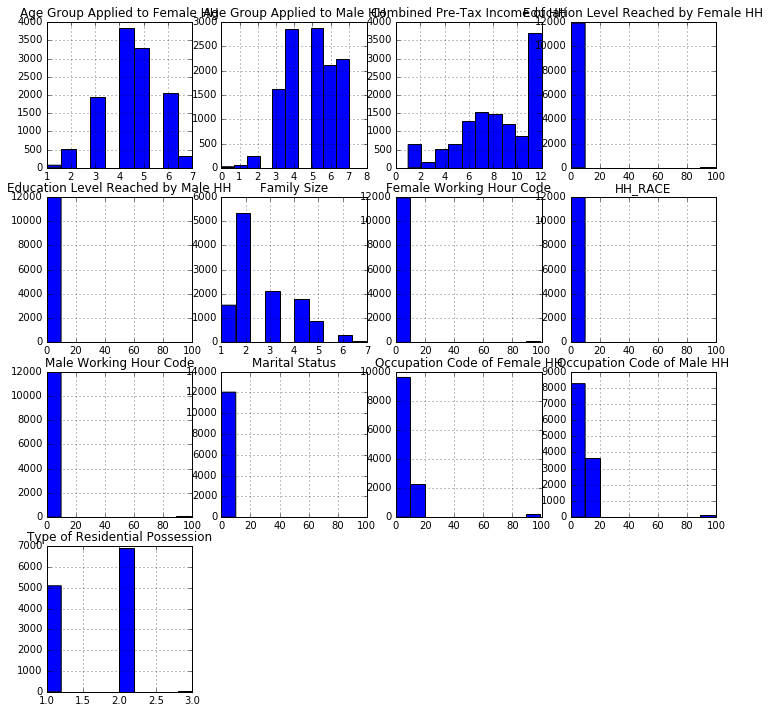

In [155]:
DEMO=demos_reduced.columns[1:]
Cluster0=data[DEMO][data['Cluster']==0]

def PlotHist(Cluster):
    plt.figure(figsize=(12,12))
    for i in range(DEMO.shape[0]):
        plt.subplot(4,4,i+1)
        Cluster[DEMO[i]].hist()
        plt.title(DEMO[i])
        
PlotHist(Cluster0)

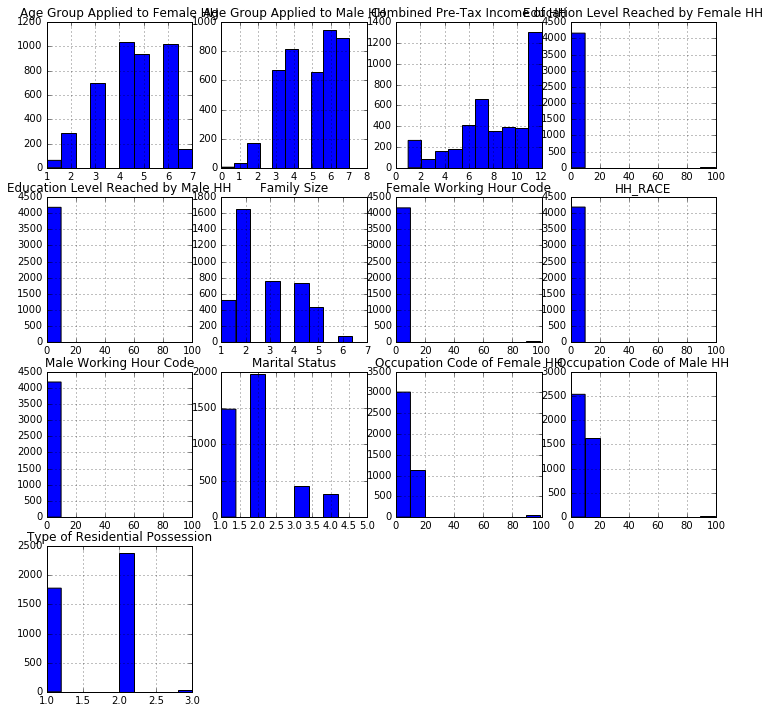

In [152]:
Cluster1=data[DEMO][data['Cluster']==1]
PlotHist(Cluster1)

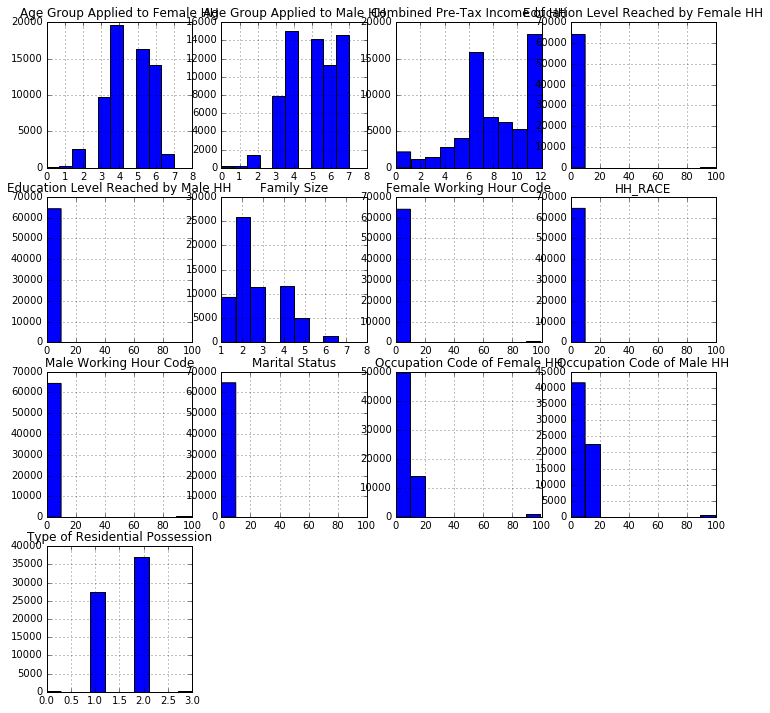

In [153]:
Cluster2=data[DEMO][data['Cluster']==2]
PlotHist(Cluster2)

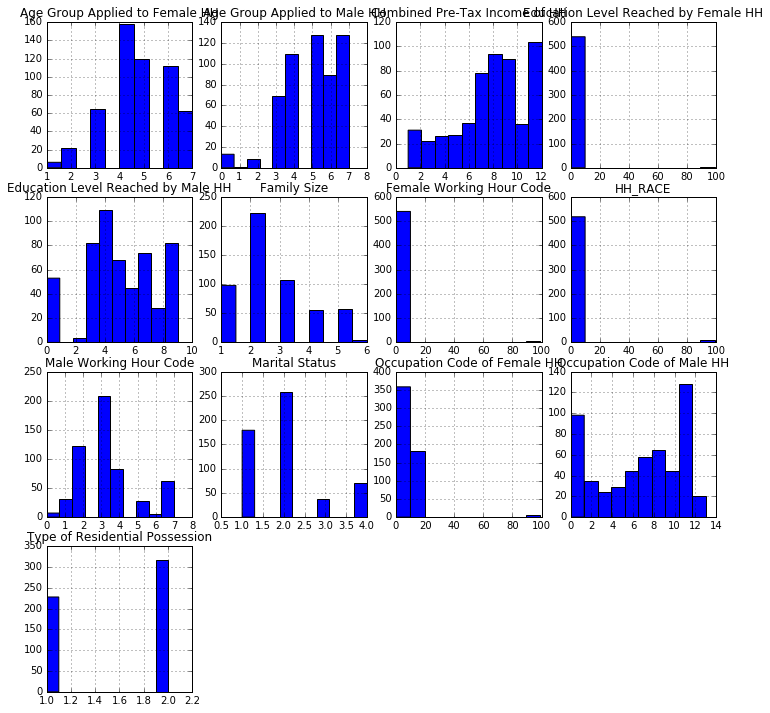

In [154]:
Cluster3=data[DEMO][data['Cluster']==3]
PlotHist(Cluster3)

Unfortunately, I don't see any patterns with the demographic data.  It appears that my theory that I could explain sales clusters using demographics was incorrect.